In [1]:
# Imports
import numpy as np
import copy as cp

# Mujoco
import mujoco
import mujoco_viewer

# Controller functions
from control.controllers.mppi_locomotion import MPPI

from utils.tasks import get_task
from utils.transforms import batch_world_to_local_velocity

# Visualization
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt

import csv
import os

## Choose paramters
#### Task:
* `'stand'` or `'stand_rugged_terr'`
* `'walk_straight'` or `'walk_straight_rugged_terr'`
* `'walk_octagon'` or `'walk_octagon_rugged_terr'`
* `'big_box'` or `'big_box_rugged_terr'`
* `'stairs'`

In [2]:
q_noise_std = 0.03  
v_noise_std = 0.2 

In [3]:
task = 'walk_straight_rugged_terr'
warm_start = True
imperfect_state_estimation = True

In [4]:
# Task
task_data = get_task(task)
model_path = task_data['sim_path']

In [5]:
# Model visualizer
model_sim = mujoco.MjModel.from_xml_path(model_path)
dt_sim = 0.01
model_sim.opt.timestep = dt_sim
data_sim = mujoco.MjData(model_sim)
viewer = mujoco_viewer.MujocoViewer(model_sim, data_sim, 'offscreen')

In [6]:
# Reset robot (keyframes are defined in the xml)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 0) # stand position
mujoco.mj_forward(model_sim, data_sim)
q_init = cp.deepcopy(data_sim.qpos) # save reference pose
v_init = cp.deepcopy(data_sim.qvel) # save reference pose
print("Configuration: {}".format(q_init)) # save reference pose

Configuration: [ 0.    0.    0.26  1.    0.    0.    0.    0.    0.9  -1.8   0.    0.9
 -1.8   0.    0.9  -1.8   0.    0.9  -1.8 ]


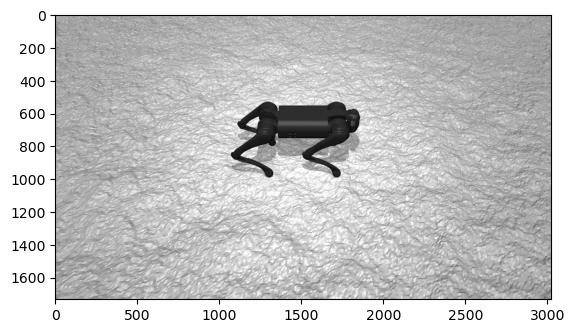

In [7]:
img = viewer.read_pixels()
plt.imshow(img)

In [8]:
# Initialize controller
controller = MPPI(task=task)
controller.internal_ref = True
controller.reset_planner()

Task:  walk_straight_rugged_terr
Initial goal 0: [0, 0, 0.27]
Initial gait in_place


In [9]:
q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
x = np.concatenate([q_curr, v_curr])

In [10]:
# Set simulation time
tfinal = 8 # 14 for stairs, 30 for walk_octagon
tvec = np.linspace(0,tfinal,int(np.ceil(tfinal/dt_sim))+1)

In [11]:
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 1)
mujoco.mj_forward(model_sim, data_sim)

In [12]:
viewer.cam.distance = 4.2
viewer.cam.lookat[:] = [2.2, 0, 0.27]

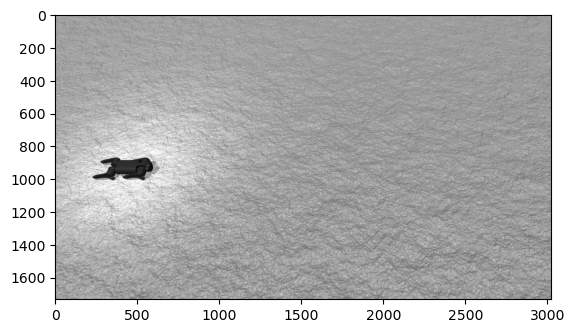

In [13]:
img = viewer.read_pixels()
plt.imshow(img)

In [14]:
%%time
# Run simulation
anim_imgs = []
sim_inputs = []
x_states = []
error_history = []
max_cost_history = []
min_cost_history = []
cost_norm_history = []
num_iter_per_goal = np.zeros(len(controller.goal_pos))

# Determine if rugged terrain is being used
rugged_terr = 'rugged_terr' in task

for ticks, ti in enumerate(tvec):
    if imperfect_state_estimation:
        q_curr = cp.deepcopy(data_sim.qpos) + np.random.normal(0, q_noise_std, size=data_sim.qpos.shape)
        v_curr = cp.deepcopy(data_sim.qvel) + np.random.normal(0, v_noise_std, size=data_sim.qvel.shape)
    else:
        q_curr = cp.deepcopy(data_sim.qpos)
        v_curr = cp.deepcopy(data_sim.qvel)
    x = np.concatenate([q_curr, v_curr])
    
    if ticks%1 == 0:
        u_joints, cost_info = controller.update(x, warm_start=warm_start)  
        max_cost_history.append(cost_info['max_cost'])
        min_cost_history.append(cost_info['min_cost'])
        cost_norm_history.append(np.linalg.norm(cost_info['max_cost'] - cost_info['min_cost']))

    data_sim.ctrl[:] = u_joints
    mujoco.mj_step(model_sim, data_sim)
    mujoco.mj_forward(model_sim, data_sim)

    error = np.linalg.norm(np.array(controller.body_ref[:3]) - np.array(data_sim.qpos[:3]))
    error_history.append(error)
    
    viewer.add_marker(
        pos=controller.body_ref[:3]*1,         # Position of the marker
        size=[0.15, 0.15, 0.15],     # Size of the sphere
        rgba=[1, 0, 1, 1],           # Color of the sphere (red)
        type=mujoco.mjtGeom.mjGEOM_SPHERE, # Specify that this is a sphere
        label=""
    )

    if error < controller.goal_thresh[controller.goal_index]:
        controller.next_goal()
    
    num_iter_per_goal[controller.goal_index] += 1
    
    img = viewer.read_pixels()
    if ticks % 2 == 0:
        anim_imgs.append(img)
    sim_inputs.append(u_joints)
    x_states.append(x)

Moved to next goal 1: [1, 0, 0.27]
Gait: walk_fast
CPU times: user 2min 13s, sys: 4.01 s, total: 2min 17s
Wall time: 1min 54s


In [15]:
import csv

# Save the time-series data
time_series_filename = f"simulation_timeseries_{rugged_terr}_{warm_start}_{imperfect_state_estimation}.csv"
with open(time_series_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['time_step', 'error_history', 'max_cost_history', 'min_cost_history', 'cost_norm_history', 'rugged_terr', 'warm_start', 'imperfect_state'])
    # Write each row of time-series data
    for i in range(len(error_history)):
        writer.writerow([
            i,
            error_history[i],
            max_cost_history[i],
            min_cost_history[i],
            cost_norm_history[i],
            rugged_terr,
            warm_start,
            imperfect_state_estimation
        ])

# Save the goal iteration data
goal_filename = f"simulation_goal_data_{rugged_terr}_{warm_start}_{imperfect_state_estimation}.csv"
with open(goal_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['goal_index', 'num_iter_per_goal'])
    # Write each row of goal data
    for i, value in enumerate(num_iter_per_goal):
        writer.writerow([i, value])

print(f"Time-series data saved to {time_series_filename}")
print(f"Goal data saved to {goal_filename}")


Time-series data saved to simulation_timeseries_True_True_True.csv
Goal data saved to simulation_goal_data_True_True_True.csv


{'Flat, Perfect State': {'Cold Start': [315.0, 486.0], 'Warm Start': []}, 'Flat, Imperfect State': {'Cold Start': [], 'Warm Start': []}, 'Bumpy, Perfect State': {'Cold Start': [], 'Warm Start': []}, 'Bumpy, Imperfect State': {'Cold Start': [], 'Warm Start': []}}
{'Flat, Perfect State': {'Cold Start': [315.0, 486.0], 'Warm Start': [318.0, 483.0]}, 'Flat, Imperfect State': {'Cold Start': [], 'Warm Start': []}, 'Bumpy, Perfect State': {'Cold Start': [], 'Warm Start': []}, 'Bumpy, Imperfect State': {'Cold Start': [], 'Warm Start': []}}
{'Flat, Perfect State': {'Cold Start': [315.0, 486.0], 'Warm Start': [318.0, 483.0]}, 'Flat, Imperfect State': {'Cold Start': [697.0, 104.0], 'Warm Start': []}, 'Bumpy, Perfect State': {'Cold Start': [], 'Warm Start': []}, 'Bumpy, Imperfect State': {'Cold Start': [], 'Warm Start': []}}
{'Flat, Perfect State': {'Cold Start': [315.0, 486.0], 'Warm Start': [318.0, 483.0]}, 'Flat, Imperfect State': {'Cold Start': [697.0, 104.0], 'Warm Start': [695.0, 106.0]}, 'B

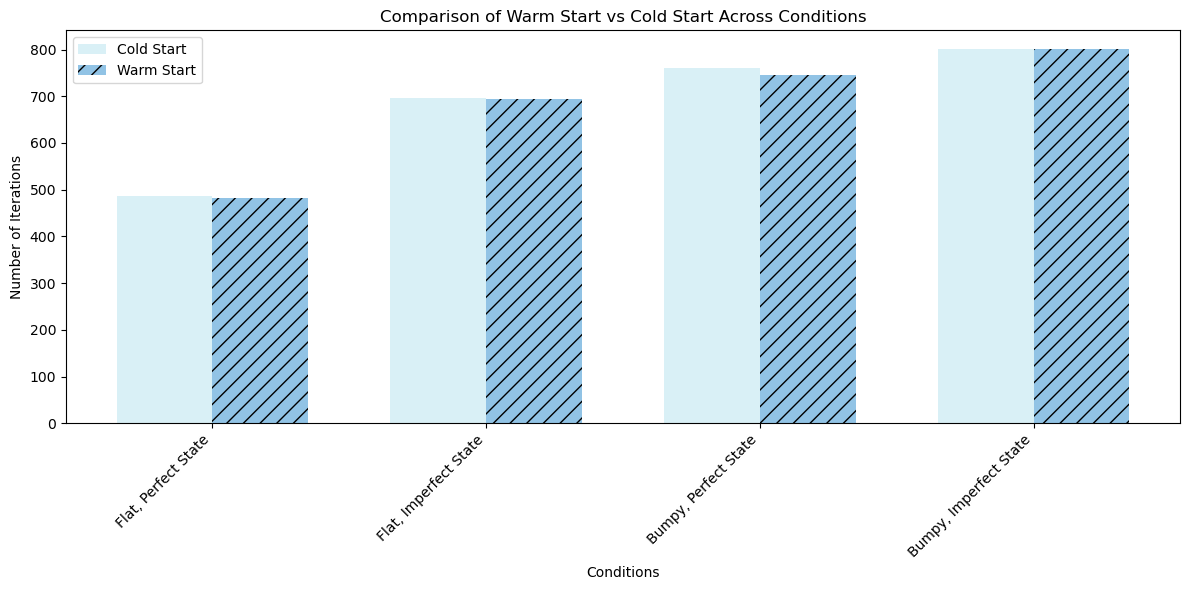

In [65]:
import csv
import matplotlib.pyplot as plt
import os
import numpy as np

# List CSV files with descriptive names and their corresponding condition keys
csv_files = [
    ("simulation_goal_data_False_False_False.csv", "Flat, Perfect State, Cold Start"),
    ("simulation_goal_data_False_True_False.csv", "Flat, Perfect State, Warm Start"),
    ("simulation_goal_data_False_False_True.csv", "Flat, Imperfect State, Cold Start"),
    ("simulation_goal_data_False_True_True.csv", "Flat, Imperfect State, Warm Start"),
    ("simulation_goal_data_True_False_False.csv", "Bumpy, Perfect State, Cold Start"),
    ("simulation_goal_data_True_True_False.csv", "Bumpy, Perfect State, Warm Start"),
    ("simulation_goal_data_True_False_True.csv", "Bumpy, Imperfect State, Cold Start"),
    ("simulation_goal_data_True_True_True.csv", "Bumpy, Imperfect State, Warm Start"),
]

# Prepare data for plotting
goal_data = {
    "Flat, Perfect State": {"Cold Start": [], "Warm Start": []},
    "Flat, Imperfect State": {"Cold Start": [], "Warm Start": []},
    "Bumpy, Perfect State": {"Cold Start": [], "Warm Start": []},
    "Bumpy, Imperfect State": {"Cold Start": [], "Warm Start": []},
}

# Read data from files
for file, label in csv_files:
    if os.path.exists(file):  # Check if the file exists
        with open(file, mode="r") as f:
            reader = csv.DictReader(f)
            num_iter = [float(row["num_iter_per_goal"]) for row in reader]

            # Determine the condition and start type
            parts = label.split(", ")
            condition = ", ".join(parts[:2])  # First two parts are the condition
            start_type = parts[2]  # Third part is the start type

            if num_iter[0] == 0:
                num_iter.pop(0)
            goal_data[condition][start_type] = num_iter
    else:
        print(f"File {file} not found!")

print(goal_data)
# Plot the data
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(goal_data))  # Number of conditions

for i, (condition, starts) in enumerate(goal_data.items()):
    cold_start = starts["Cold Start"][:2]  # Goals 1 and 2
    warm_start = starts["Warm Start"][:2]

    # Plot cold start bars
    plt.bar(
        x[i] - bar_width / 2, cold_start, bar_width,
        color="#d9f0f6",label="Cold Start" if i == 0 else ""
    )

    # Plot warm start bars with hatching
    plt.bar(
        x[i] + bar_width / 2, warm_start, bar_width,
        color="#91c3e5", hatch="//", label="Warm Start" if i == 0 else ""
    )

# Add labels, title, and legend
plt.title("Comparison of Warm Start vs Cold Start Across Conditions")
plt.xlabel("Conditions")
plt.ylabel("Number of Iterations")
plt.xticks(x, goal_data.keys(), rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/6z/bwfg2lk12_7c8xhbmnv9sjw80000gn/T/ipykernel_28875/2154609937.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


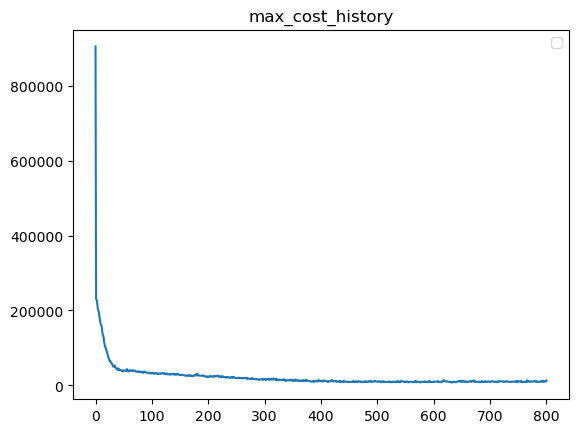

In [17]:
plt.plot(max_cost_history)
plt.title("max_cost_history")
plt.legend()

/var/folders/6z/bwfg2lk12_7c8xhbmnv9sjw80000gn/T/ipykernel_28875/2543610374.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


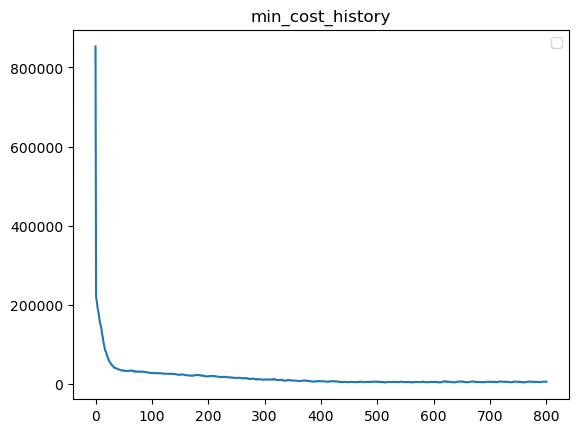

In [18]:
plt.plot(min_cost_history)
plt.title("min_cost_history")
plt.legend()

/var/folders/6z/bwfg2lk12_7c8xhbmnv9sjw80000gn/T/ipykernel_28875/508193682.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


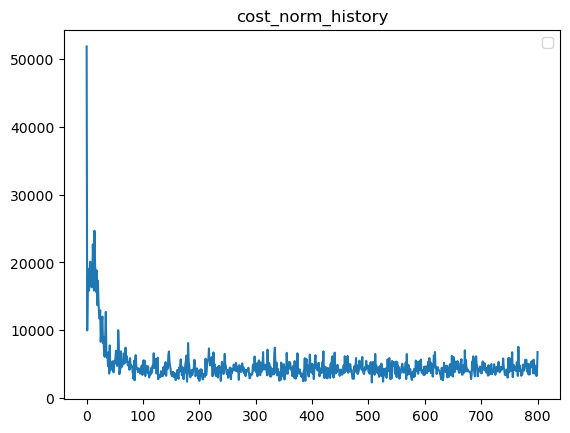

In [19]:
plt.plot(cost_norm_history)
plt.title("cost_norm_history")
plt.legend()

/var/folders/6z/bwfg2lk12_7c8xhbmnv9sjw80000gn/T/ipykernel_28875/4135399545.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


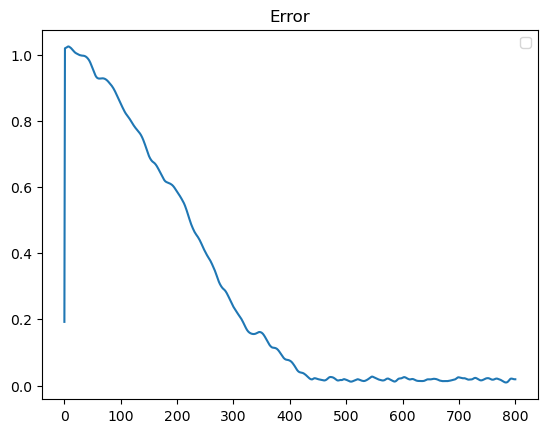

In [20]:
plt.plot(error_history)
plt.title("Error")
plt.legend()

In [21]:
sim_inputs_np = np.array(sim_inputs)

## Animation

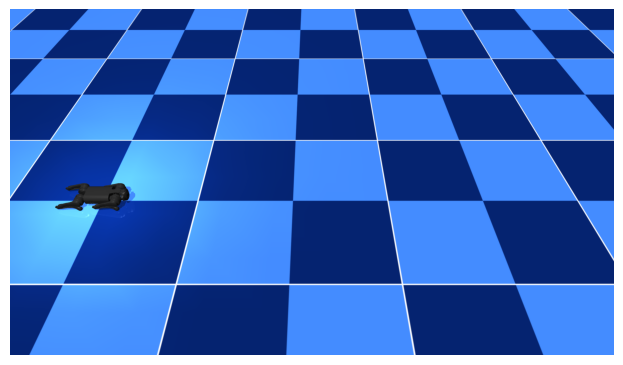

In [22]:
# Get the resolution of the images
image_height, image_width = anim_imgs[0].shape[:2]

# Set the figure size to match the image resolution
fig, ax = plt.subplots(figsize=(image_width / 500, image_height / 500), dpi=100)
skip_frames = 5
interval = dt_sim*1000*skip_frames
# Remove the white border by setting margins and padding to zero
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.set_position([0, 0, 1, 1])

def animate(i):
    ax.clear()
    ax.imshow(anim_imgs[i * skip_frames])  # Display the image, skipping frames
    ax.axis('off')

# Create animation, considering the reduced frame rate due to skipped frames
ani = FuncAnimation(fig, animate, frames=len(anim_imgs) // skip_frames, interval=interval)  # 50 ms for 20 Hz

# Display the animation
HTML(ani.to_jshtml())

In [26]:
# Save the animation
ani.save('{}.mov'.format(task), writer='ffmpeg', fps=20, codec='prores', bitrate=-1, extra_args=['-pix_fmt', 'yuv420p'])

MovieWriter ffmpeg unavailable; using Pillow instead.


TypeError: __init__() got an unexpected keyword argument 'extra_args'

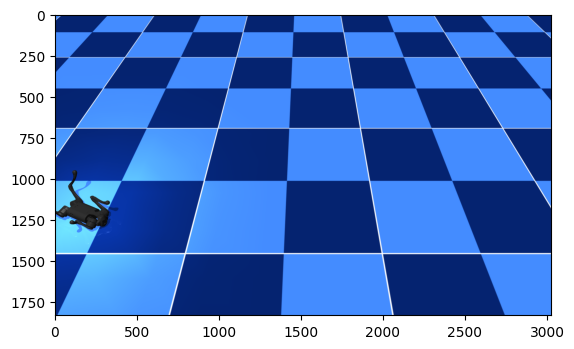

In [27]:
plt.imshow(anim_imgs[-1])